In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.model import HetMOGP
from hetmogp import multi_output
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
M = 10  # number of inducing points
Q = 1  # number of latent functions

# Heterogeneous Likelihood Definition
# likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
#likelihoods_list = [Bernoulli(), Bernoulli()] # Real + Binary
likelihoods_list = [Gaussian(sigma=1.),Gaussian(sigma=1.)]

likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)



In [27]:
template = np.array([0,0,0,1,1,0,1,1,0,1,1,0])
X1 = []
Y1 = []
X2 = []
Y2 = []
tiles = 4
for tilex in range(tiles):
    for tiley in range(tiles):
        templateadjusted = template.copy()
        templateadjusted[0::2]+=tilex
        templateadjusted[1::2]+=tiley
        X1.append(templateadjusted)
        Y1.append(tilex+tiley)

for tilex in range(int(tiles/2)):
    for tiley in range(int(tiles/2)):
        templateadjusted = template.copy()
        templateadjusted[0::2]+=tilex
        templateadjusted[1::2]+=tiley
        X2.append(templateadjusted*2)
        Y2.append(tilex+tiley)
X1 = np.array(X1)
Y1 = np.array(Y1)
X2 = np.array(X2)
Y2 = np.array(Y2)

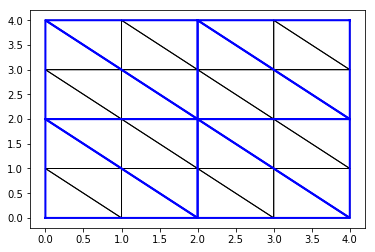

In [28]:
def plotsimplexes(X,c,lw=1):
    for x in X:
        for tri in x.reshape(int(len(x)/6),6):
            plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c,lw=lw)
plotsimplexes(X1,'k-')
plotsimplexes(X2,'b-',lw=2)

In [29]:
#X = [x1_new, x2_new]
X = [X1,X2]

In [30]:
Y = [Y1[:,None], Y2[:, None]]

In [31]:
Q

1

In [32]:
X[0].shape

(16, 12)

In [33]:
#kern = GPy.kern.RBF(2, lengthscale=ls, variance = var, ARD=False)
#oldshapek = ShapeIntegral(X.shape[1],input_space_dim=2,Nperunit=Nper,kernel=kern)


In [227]:
# Written by Mike Smith michaeltsmith.org.uk

from GPy.kern import Kern
from GPy.core.parameterization import Param
from paramz.transformations import Logexp
import math
from scipy.misc import factorial
import numpy as np
import math
import random

#TODO: Is it ok for us to just fill the rest of X in with zeros?
# these won't have any points chosen in those 0-volume areas... but ideally we should do something else? Put NaNs in????

#round (by probability)
#https://stackoverflow.com/questions/19045971/random-rounding-to-integer-in-python
def prob_round(x):
    sign = np.sign(x)
    x = abs(x)
    is_up = random.random() < x-int(x)
    round_func = math.ceil if is_up else math.floor
    return int(sign * round_func(x))


class ShapeIntegral(Kern):
    """
    
    """

    def __init__(self, input_dim, input_space_dim=None, active_dims=None, kernel=None, name='shapeintegral',Nperunit=100):
        """
        NOTE: Added input_space_dim as the number of columns in X isn't the dimensionality of the space. I.e. for pentagons there
        will be 10 columns in X, while only 2 dimensions of input space.
        
        The lengthscale, variance, etc are ideally set by specifying the kernel we'll use
        
        input_dim = number of actual columns in data
        input_space_dim = number of dimensions in the domain
        active_dims = potential list of dimensions we'll use
        kernel = latent function kernel
        Nperunit = resolution of approximation
        
        The last column of X should specify if it's the latent function or the integral that the Y refers to.
        if it's the latent function then we just use the first d-columns, and the rest can be NaN, e.g.
        X                               Y
        0,0,1,0,0,1,0,0,1,1,0,1,1,0     2
        1,1,nanananananananananan,1     3
        is a 1x1 square with an integral of 2, and a single point in the [1,1] corner of the square with a value of 3.
        
        """
        super(ShapeIntegral, self).__init__(input_dim, active_dims, name)
        
        assert ((kernel is not None) or (input_space_dim is not None)), "Need either the input space dimensionality defining or the latent kernel defining (to infer input space)"
        if kernel is None:
            kernel = RBF(input_space_dim)
        else:
            input_space_dim = kernel.input_dim
        assert kernel.input_dim == input_space_dim, "Latent kernel (dim=%d) should have same input dimensionality as specified in input_space_dim (dim=%d)" % (kernel.input_dim,input_space_dim)
        
        
        #assert len(kern.lengthscale)==input_space_dim, "Lengthscale of length %d, but input space has %d dimensions" % (len(lengthscale),input_space_dim)

        #self.lengthscale = Param('lengthscale', kernel.lengthscale, Logexp()) #Logexp - transforms to allow positive only values...
        #self.variance = Param('variance', kernel.variance, Logexp()) #and here.
        #self.link_parameters(self.variance, self.lengthscale) #this just takes a list of parameters we need to optimise.
        
        self.kernel = kernel
        self.Nperunit = Nperunit
        self.input_space_dim = input_space_dim
        self.cached_points = {} #this is important, not only is it a speed up - we also get the same points for each shape, which makes our covariances more stable
        

    def simplexRandom(self,vectors):
        #vectors = np.array([[0,0],[0,2],[1,1]])
        """
        Compute random point in arbitrary simplex

        from Grimme, Christian. Picking a uniformly
        random point from an arbitrary simplex.
        Technical Report. University of M\:{u}nster, 2015.

        vectors are row-vectors describing the
        vertices of the simplex, e.g.
        [[0,0],[0,2],[1,1]] is a triangle
        """
        d = vectors.shape[1]
        n = vectors.shape[0]
        assert n == d+1, "Need exactly d+1 vertices to define a simplex (e.g. a 2d triangle needs 3 points, a 3d tetrahedron 4 points, etc). Currently have %d points and %d dimensions" % (n,d)

        zs = np.r_[1,np.random.rand(d),0]
        ls = zs**(1.0/np.arange(len(zs)-1,-1,-1))
        vs = np.cumprod(ls) #could skip last element for speed
        res = vectors.copy()
        res = np.zeros(d)
        for vect,l,v in zip(vectors.copy(),ls[1:],vs):
            res+=(1-l)*v*vect
        return res

    def simplexVolume(self, vectors):
        """Returns the volume of the simplex defined by the
        row vectors in vectors, e.g. passing [[0,0],[0,2],[2,0]]
        will return 2 (as this triangle has area of 2)"""
        assert vectors.shape[0]==self.input_space_dim+1, "For a %d dimensional space there should be %d+1 vectors describing the simplex" % (self.input_space_dim, self.input_space_dim)
        return np.abs(np.linalg.det(vectors[1:,:]-vectors[0,:]))/factorial(self.input_space_dim)
        
    def delete_cache(self):
        self.cached_points = {}
      
    def polytopeVolume(self, shape):
        Ncoords = self.input_space_dim*(self.input_space_dim+1)
        vol = 0
        for i in range(0,len(shape),Ncoords):
            vectors = np.array(shape[i:(i+Ncoords)].reshape(self.input_space_dim+1,self.input_space_dim))
            if np.isnan(vectors[0,0]):
                break
            vol += self.simplexVolume(vectors)
        return vol
            
            
            
    def placepoints(self,shape,Nperunit=100):
        """Places uniformly random points in shape, where shape
        is defined by an array of concatenated simplexes
        e.g. a 2x2 square (from [0,0] to [2,2]) could be built
        of two triangles:
        [0,0,0,2,2,0 ,2,2,0,2,2,0]"""
        
        #caching is vital to the algorithm's computed covariance matrix
        #we don't want to cause non-positive-definite matrices
        tuplehash = tuple(shape.tolist()) #TODO Add Nperunit to hash
        if tuplehash in self.cached_points:
            return self.cached_points[tuplehash]
            
            
        allps = []
        #each simplex in shape must have D*(D+1) coordinates, e.g. a triangle has 2*(2+1) = 6 coords (2 for each vertex)
        #e.g. a tetrahedron has 4 points, each with 3 coords = 12: 3*(3+1) = 12.
        
        Ncoords = self.input_space_dim*(self.input_space_dim+1)
        assert len(shape)%Ncoords == 0, "The number of coordinates (%d) describing the simplexes that build the shape must factorise into the number of coordinates in a single simplex in %d dimensional space (=%d)" % (len(shape), self.input_space_dim, Ncoords)
        
        totalvol = 0
        vols = []
        for i in range(0,len(shape),Ncoords):
            vectors = np.array(shape[i:(i+Ncoords)].reshape(self.input_space_dim+1,self.input_space_dim))
            if np.isnan(vectors[0,0]):
                break
            vol = self.simplexVolume(vectors)
            totalvol += vol
            vols.append(vol)

        totalexpectednpoints = 0
        totalnpoints = 0
        for i,vol in zip(range(0,len(shape),Ncoords),vols):
            vectors = shape[i:(i+Ncoords)].reshape(self.input_space_dim+1,self.input_space_dim)
            if np.isnan(vectors[0,0]):
                break
            npoints = prob_round(Nperunit*vol/totalvol)
            totalexpectednpoints += Nperunit*vol/totalvol
            totalnpoints += npoints
      #      if (totalnpoints<totalexpectednpoints-1) and (vol>0):
      #          npoints+=1
      #      if (totalnpoints>totalexpectednpoints+1) and (npoints>=1):
      #          npoints-=1
                
            points = np.array([self.simplexRandom(vectors) for i in range(npoints)])
            allps.extend(points)
            
        self.cached_points[tuplehash] = (np.array(allps),totalvol)
        return np.array(allps),totalvol
        
    def k_xx(self,X,X2=None):
        """Calculates K_xx without the variance term
        
        X is in the form of an array *for one shape*. it
        is defined by an array of concatenated simplexes
        e.g. a 2x2 square (from [0,0] to [2,2]) could be built
        of two triangles:
        [0,0,0,2,2,0 ,2,2,0,2,2,0]
        """
        if X2 is None:
            X2 = X
        ps, vp = self.placepoints(X,self.Nperunit)
        qs, vq = self.placepoints(X2,self.Nperunit)            
        cov = self.kernel.K(ps,qs)
        v = vp*vq*np.sum(cov)/np.prod(cov.shape) #(self.Nperunit*self.Nperunit)
        return v
        
    def k_xf(self,X,X2):
        """Calculates K_xf without the variance term
        
        X2 is in the form of an single row, one shape. It
        is defined by an array of concatenated simplexes
        e.g. a 2x2 square (from [0,0] to [2,2]) could be built
        of two triangles:
        [0,0,0,2,2,0 ,2,2,0,2,2,0]
        
        X is a list of coordinates.
        """
        
        #assert X.shape[1]==self.kernel.input_dim, "First term (X) should be locations of points in latent space. Second term should be shapes of integrals."

        ps, vp = self.placepoints(X2,self.Nperunit)
        cov = self.kernel.K(ps,X)
        
        
        cov = self.kernel.K(ps,qs)
        v = vp*np.sum(cov)/np.prod(cov.shape) #(self.Nperunit*self.Nperunit)

        return v
    
    def k_ff(self,X,X2):
        return self.kernel.K(X,X2)
       

    def k(self,x,x2):
        """Helper function to compute covariance in one dimension (idx) between a pair of points.
        The last element in x and x2 specify if these are integrals (0) or latent values (1).
        l = that dimension's lengthscale
        """
        
        if (x[-1]==0) and (x2[-1]==0):
            return self.k_xx(x[:-1],x2[:-1])
        if (x[-1] == 0) and (x2[-1] == 1):
            return self.k_xf(x[:-1],x2[:-1])
        if (x[-1] == 1) and (x2[-1] == 0):
            return self.k_xf(x2[:-1],x[:-1])
        if (x[-1]==1) and (x2[-1]==1):
            return self.k_ff(x[:-1],x2[:-1])
        assert False, "Invalid choice of latent/integral parameter (set the last column of X to 0s and 1s to select this)"

        
    def update_gradients_full(self, dL_dK, X, X2=None):
        """
        Not solved - this needs doing (pass the results from the latent kernel)
        """
        pass

    def update_gradients_diag(self, dL_dKdiag, X):
        """
        Not solved - this needs doing (pass the results from the latent kernel)
        """
        pass       
            
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        K_xx = np.ones([X.shape[0],X2.shape[0]]) #ones now as a product occurs over each dimension
        for i,x in enumerate(X):
            for j,x2 in enumerate(X2):
                #for il,l in enumerate(self.kernel.lengthscale):
                #    idx = il*2 #each pair of input dimensions describe the limits on one actual dimension in the data
                K_xx[i,j] *= self.k(x,x2)
        return K_xx# * self.variances[0] #TODO - is this ok???
            

    def Kdiag(self, X):
        return np.diag(self.K(X))

In [228]:
# KERNELS
input_dim = 13
ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
#from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
kern_list = []
kern_list.append(ShapeIntegral(input_dim,2,kernel=GPy.kern.RBF(2)))
#kern_list = multi_output.latent_functions_prior(Q, lengthscale=[ls_q], variance=[var_q], input_dim=input_dim,kernel=ShapeIntegral)

# My kernel needs to get the lengthscale like this for two dimesional data lenghtscale=[1.0, 1.0]
# It doesn't need to be on, just two numbers
# Although my data looks 5 dimensional it is actually two dimensional and the kernel handles that in the background)

In [229]:
X1wzeros = np.c_[X1,np.zeros([len(X1),1])]

In [230]:
k = ShapeIntegral(input_dim,2,kernel=GPy.kern.RBF(2),Nperunit=2)
m = GPy.models.GPRegression(X1wzeros,Y1[:,None],k)

GP_regression.,value,constraints,priors
Gaussian_noise.variance,1.0,+ve,


In [195]:
debug

> <ipython-input-190-c648bfc5c7bb>(306)calc_K_xx_wo_variance()
    304                 #for il,l in enumerate(self.kernel.lengthscale):
    305                 #    idx = il*2 #each pair of input dimensions describe the limits on one actual dimension in the data
--> 306                 K_xx[i,j] *= self.k(x,x2)
    307         return K_xx
    308 

ipdb> x
ObsAr([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.])
ipdb> x2
ObsAr([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.])
ipdb> q


In [200]:
k.k(np.array([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.]),np.array([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.]))

array([[1.        , 0.94150335],
       [0.94150335, 1.        ]])

In [184]:
plt.scatter(Y1,m.predict(X1)[0])

KeyboardInterrupt: 

In [46]:
k.calc_K_xx_wo_variance(X[0],X[0])

array([[9.24256666e-01, 5.89495977e-01, 1.19209143e-01, 5.39121060e-03,
        5.15245623e-01, 3.15582370e-01, 6.17816300e-02, 1.26605171e-02,
        7.97496584e-02, 1.25641165e-01, 4.21937513e-02, 7.20908253e-03,
        2.50531103e-02, 9.43115309e-03, 1.98995535e-03, 4.66242818e-04],
       [5.89495977e-01, 9.07142539e-01, 5.17558344e-01, 7.29026220e-02,
        3.31225304e-01, 4.42603013e-01, 2.87889693e-01, 9.09281207e-02,
        5.30621530e-02, 1.54426526e-01, 9.68518107e-02, 4.11497931e-02,
        1.51615868e-02, 1.47001743e-02, 5.27712320e-03, 3.04788570e-03],
       [1.19209143e-01, 5.17558344e-01, 9.27779263e-01, 4.63599091e-01,
        6.27118294e-02, 2.36124292e-01, 6.00786909e-01, 3.43997185e-01,
        8.65016026e-03, 5.85733599e-02, 8.81417381e-02, 1.35931917e-01,
        1.76929708e-03, 8.17368146e-03, 6.31630191e-03, 1.33857732e-02],
       [5.39121060e-03, 7.29026220e-02, 4.63599091e-01, 8.53331337e-01,
        4.84780946e-03, 5.67638611e-02, 4.14356154e-01, 4.540

In [141]:
Z = np.array([[1.0,2.0],[3.0,4.0]])
cov = k.calc_K_xf_wo_variance(Z,X[0])

In [169]:
tempX = np.array([[0,0,0,0.01,0.01,0]])
tempZ = tempX.copy()
tempZ[:,0::2]=tempZ[:,0::2]+1
tempZ[:,1::2]=tempZ[:,1::2]+2
#tempX[:,0::2]=tempX[:,0::2]+0.0001
k.Nperunit=10000
k.delete_cache()
cov = k.calc_K_xf_wo_variance(Z,tempX)

In [170]:
len(k.cached_points[tuple(tempX[0].tolist())][0])

10000

In [172]:
k.kernel.K(Z,np.array([[0.005,0.005]]))*((0.0001/2))

array([[4.16617357e-06],
       [1.92964949e-10]])

In [173]:
cov

array([[4.14545474e-06, 1.90732115e-10]])

In [13]:
def callback(i):
    if i['n_iter'] > 1500:
        return True
    return False

In [14]:
X_ = np.vstack((X[0], X[1]))
from sklearn.cluster import KMeans
kmeans_X = KMeans(n_clusters=10, random_state=0).fit(X_)
Z = kmeans_X.cluster_centers_
Z[:,-1] = 1

In [16]:
Z

array([[5.58333333, 1.16666667, 5.58333333, 2.41666667, 6.83333333,
        1.16666667, 6.83333333, 2.41666667, 5.58333333, 2.41666667,
        6.83333333, 1.        ],
       [3.83333333, 4.91666667, 3.83333333, 6.16666667, 5.08333333,
        4.91666667, 5.08333333, 6.16666667, 3.83333333, 6.16666667,
        5.08333333, 1.        ],
       [7.42857143, 4.85714286, 7.42857143, 6.        , 8.57142857,
        4.85714286, 8.57142857, 6.        , 7.42857143, 6.        ,
        8.57142857, 1.        ],
       [0.77777778, 0.77777778, 0.77777778, 1.88888889, 1.88888889,
        0.77777778, 1.88888889, 1.88888889, 0.77777778, 1.88888889,
        1.88888889, 1.        ],
       [7.375     , 7.75      , 7.375     , 9.        , 8.625     ,
        7.75      , 8.625     , 9.        , 7.375     , 9.        ,
        8.625     , 1.        ],
       [0.85714286, 7.21428571, 0.85714286, 8.42857143, 2.07142857,
        7.21428571, 2.07142857, 8.42857143, 0.85714286, 8.42857143,
        2.07142857,

In [19]:
X1.shape

(100, 12)

In [20]:
# MODEL and INFERENCE
model = HetMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)

NotImplementedError: 

In [ ]:
vem_model=VEM(model,vem_iters=5,maxIter_perVEM=100,optZ=False,verbose=False,verbose_plot=False,non_chained=True)

In [ ]:
model.kern

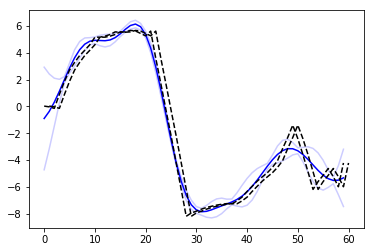

In [152]:
mean,var = model.predictive(np.c_[X1,np.zeros(len(X1))],output_function_ind=1)
plt.plot(mean,'b-')
plt.plot(mean+np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(mean-np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(X1,correct,'k--')